### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Nov 25 19:47:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


**NOTE:** When training YOLO11, make sure your data is located in `{HOME}/datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. When downloading data from [Roboflow Universe](https://universe.roboflow.com/), use the YOLOv8 format.

In [5]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet


import roboflow

roboflow.login()

rf = roboflow.Roboflow()
project = rf.workspace("dotdetection").project("pointkneedetectionv5")
dataset = project.version(16).download("yolov8")


/content/datasets
You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to PointKneeDetectionV5-16 in yolov8:: 100%|██████████| 146/146 [00:00<00:00, 8016.97it/s]


**NOTE:** Make sure to run commands below to make dataset work with YOLO11 training.

In [6]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

## Custom Training

In [8]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11n-pose.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 5.97M/5.97M [00:00<00:00, 304MB/s]
WARNING ⚠️ conflicting 'task=detect' passed with 'task=pose' model. Ignoring 'task=detect' and updating to 'task=pose' to match model.
Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolo11n-pose.pt, data=/content/datasets/PointKneeDetectionV5-16/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=F

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [11]:
!ls {HOME}/runs/pose/train/

args.yaml					    labels_correlogram.jpg  train_batch0.jpg
BoxF1_curve.png					    labels.jpg		    train_batch1.jpg
BoxP_curve.png					    PoseF1_curve.png	    train_batch2.jpg
BoxPR_curve.png					    PoseP_curve.png	    val_batch0_labels.jpg
BoxR_curve.png					    PosePR_curve.png	    val_batch0_pred.jpg
confusion_matrix_normalized.png			    PoseR_curve.png	    weights
confusion_matrix.png				    results.csv
events.out.tfevents.1732564251.9b8c80bda595.1614.0  results.png


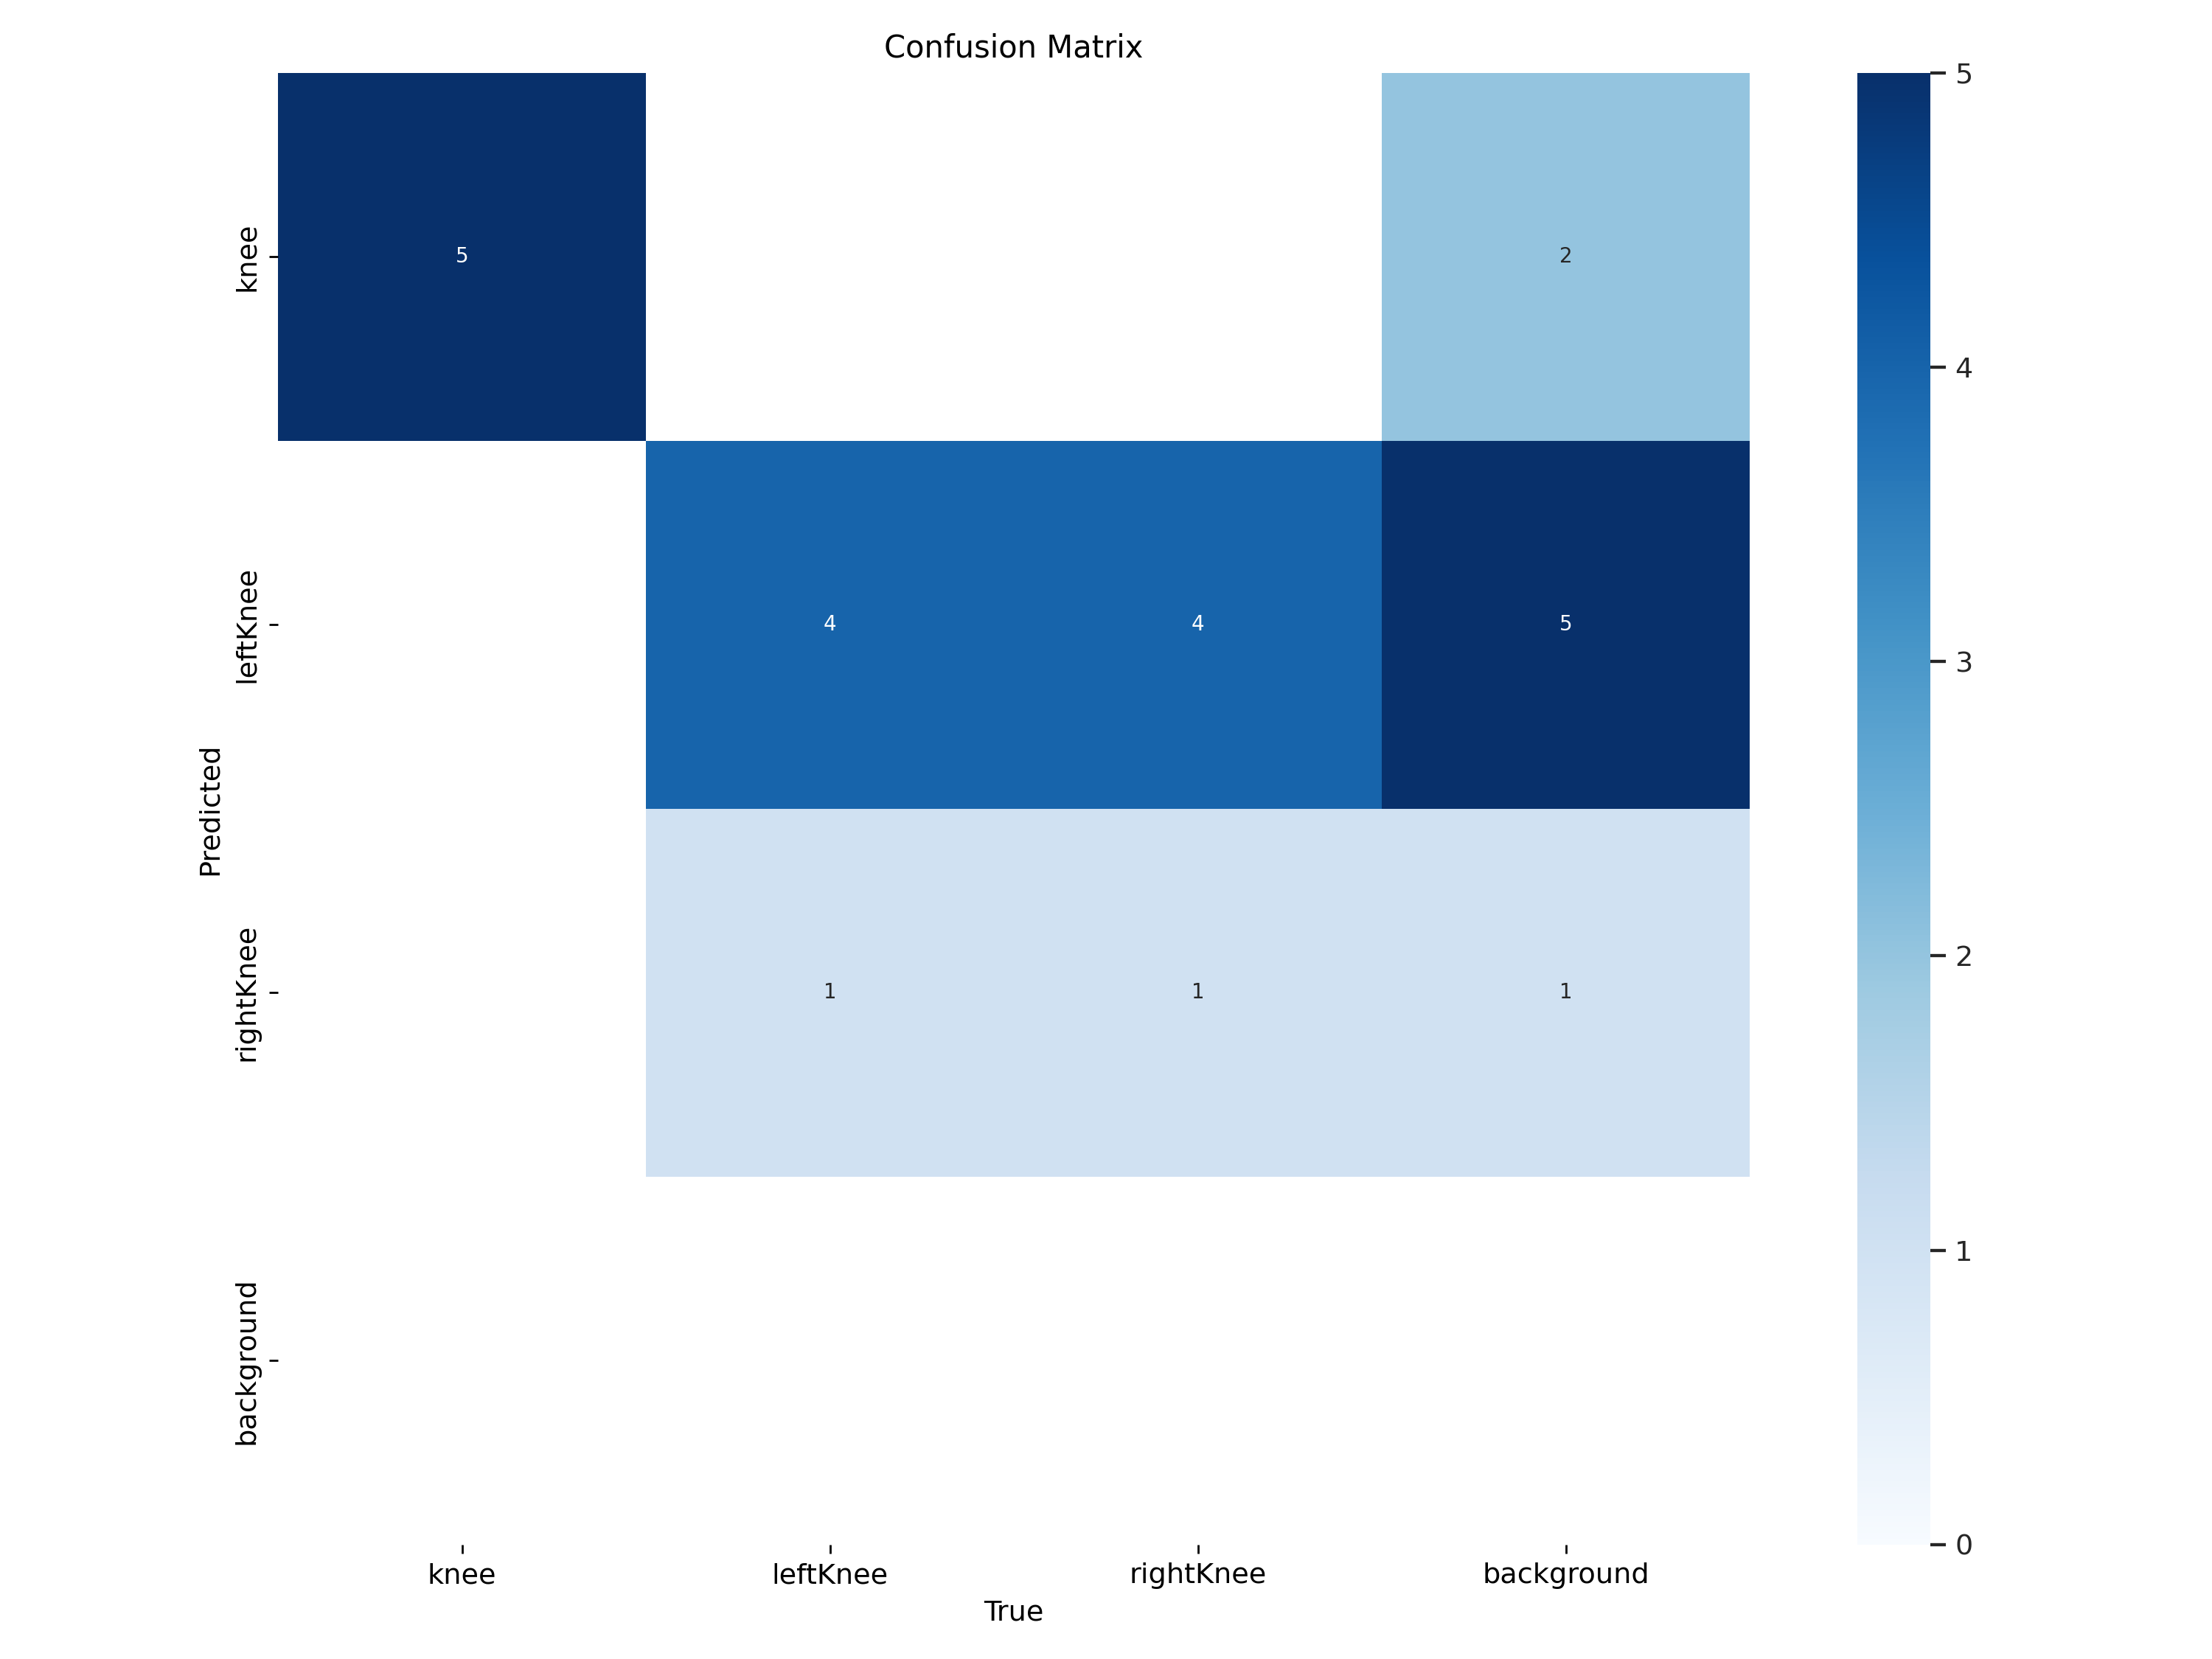

In [12]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/pose/train/confusion_matrix.png', width=600)

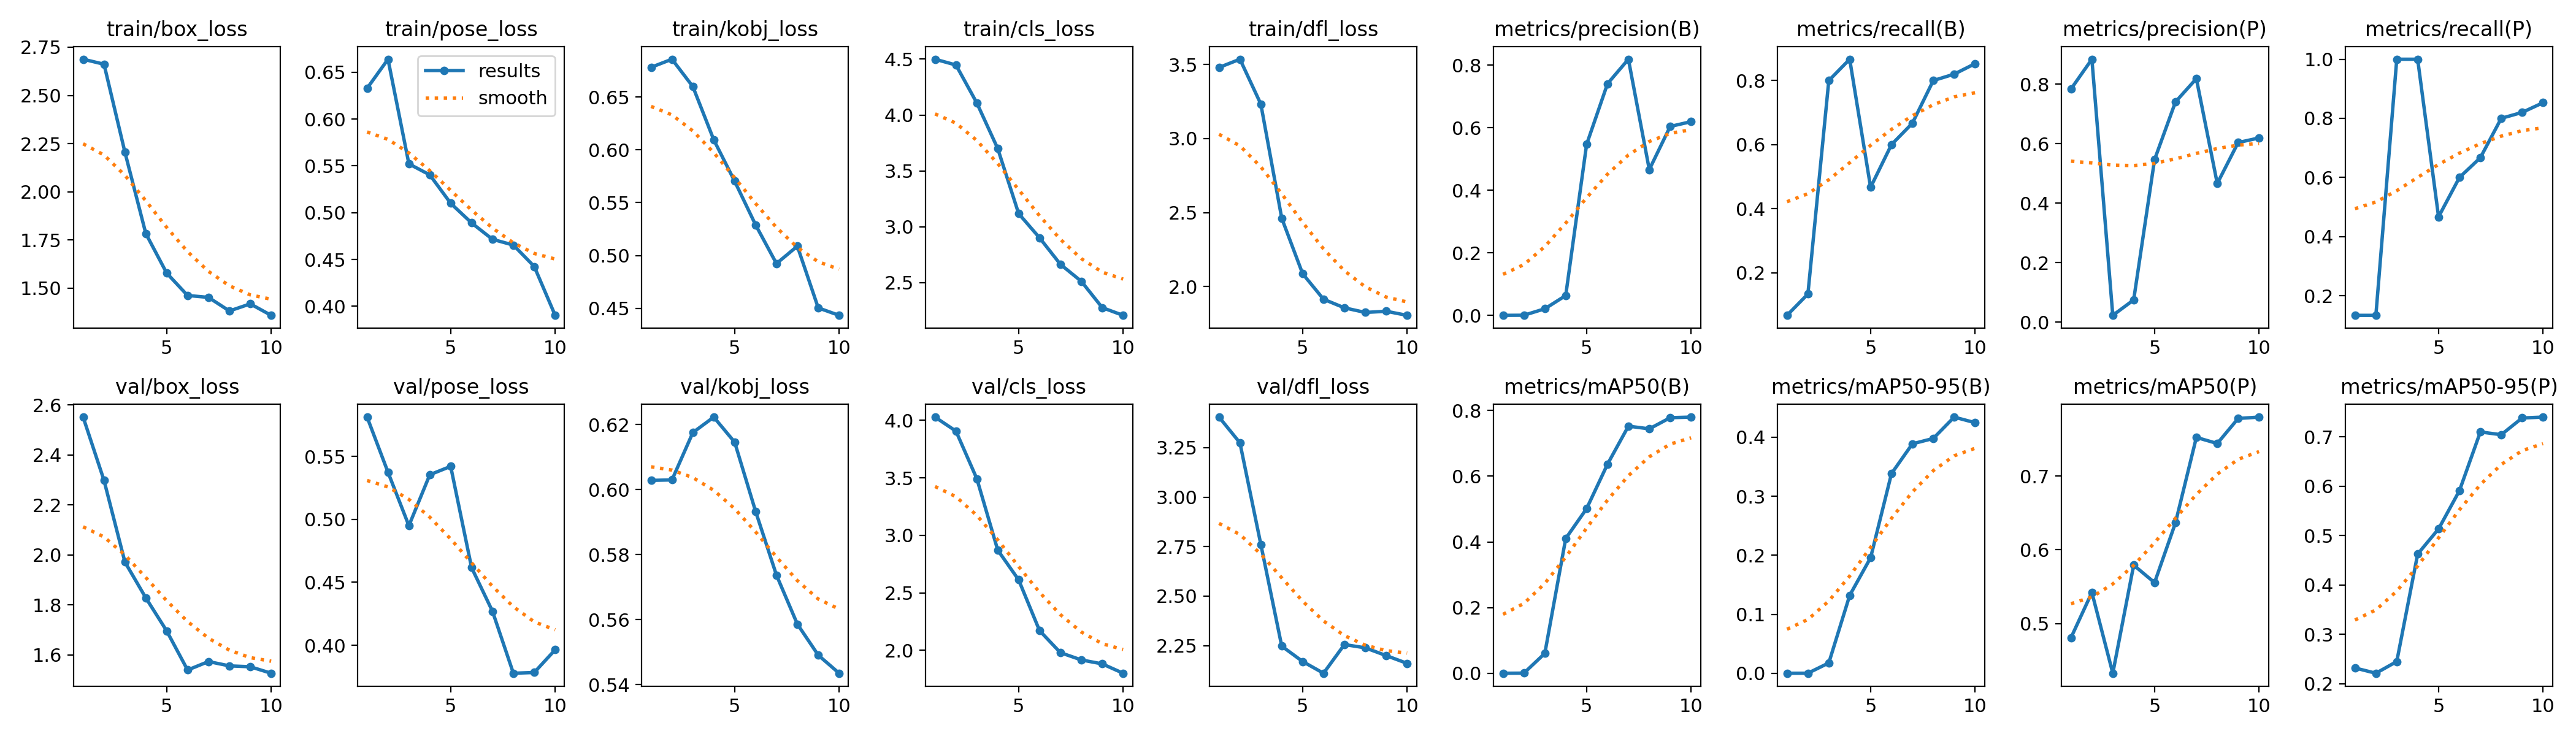

In [13]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/pose/train/results.png', width=600)

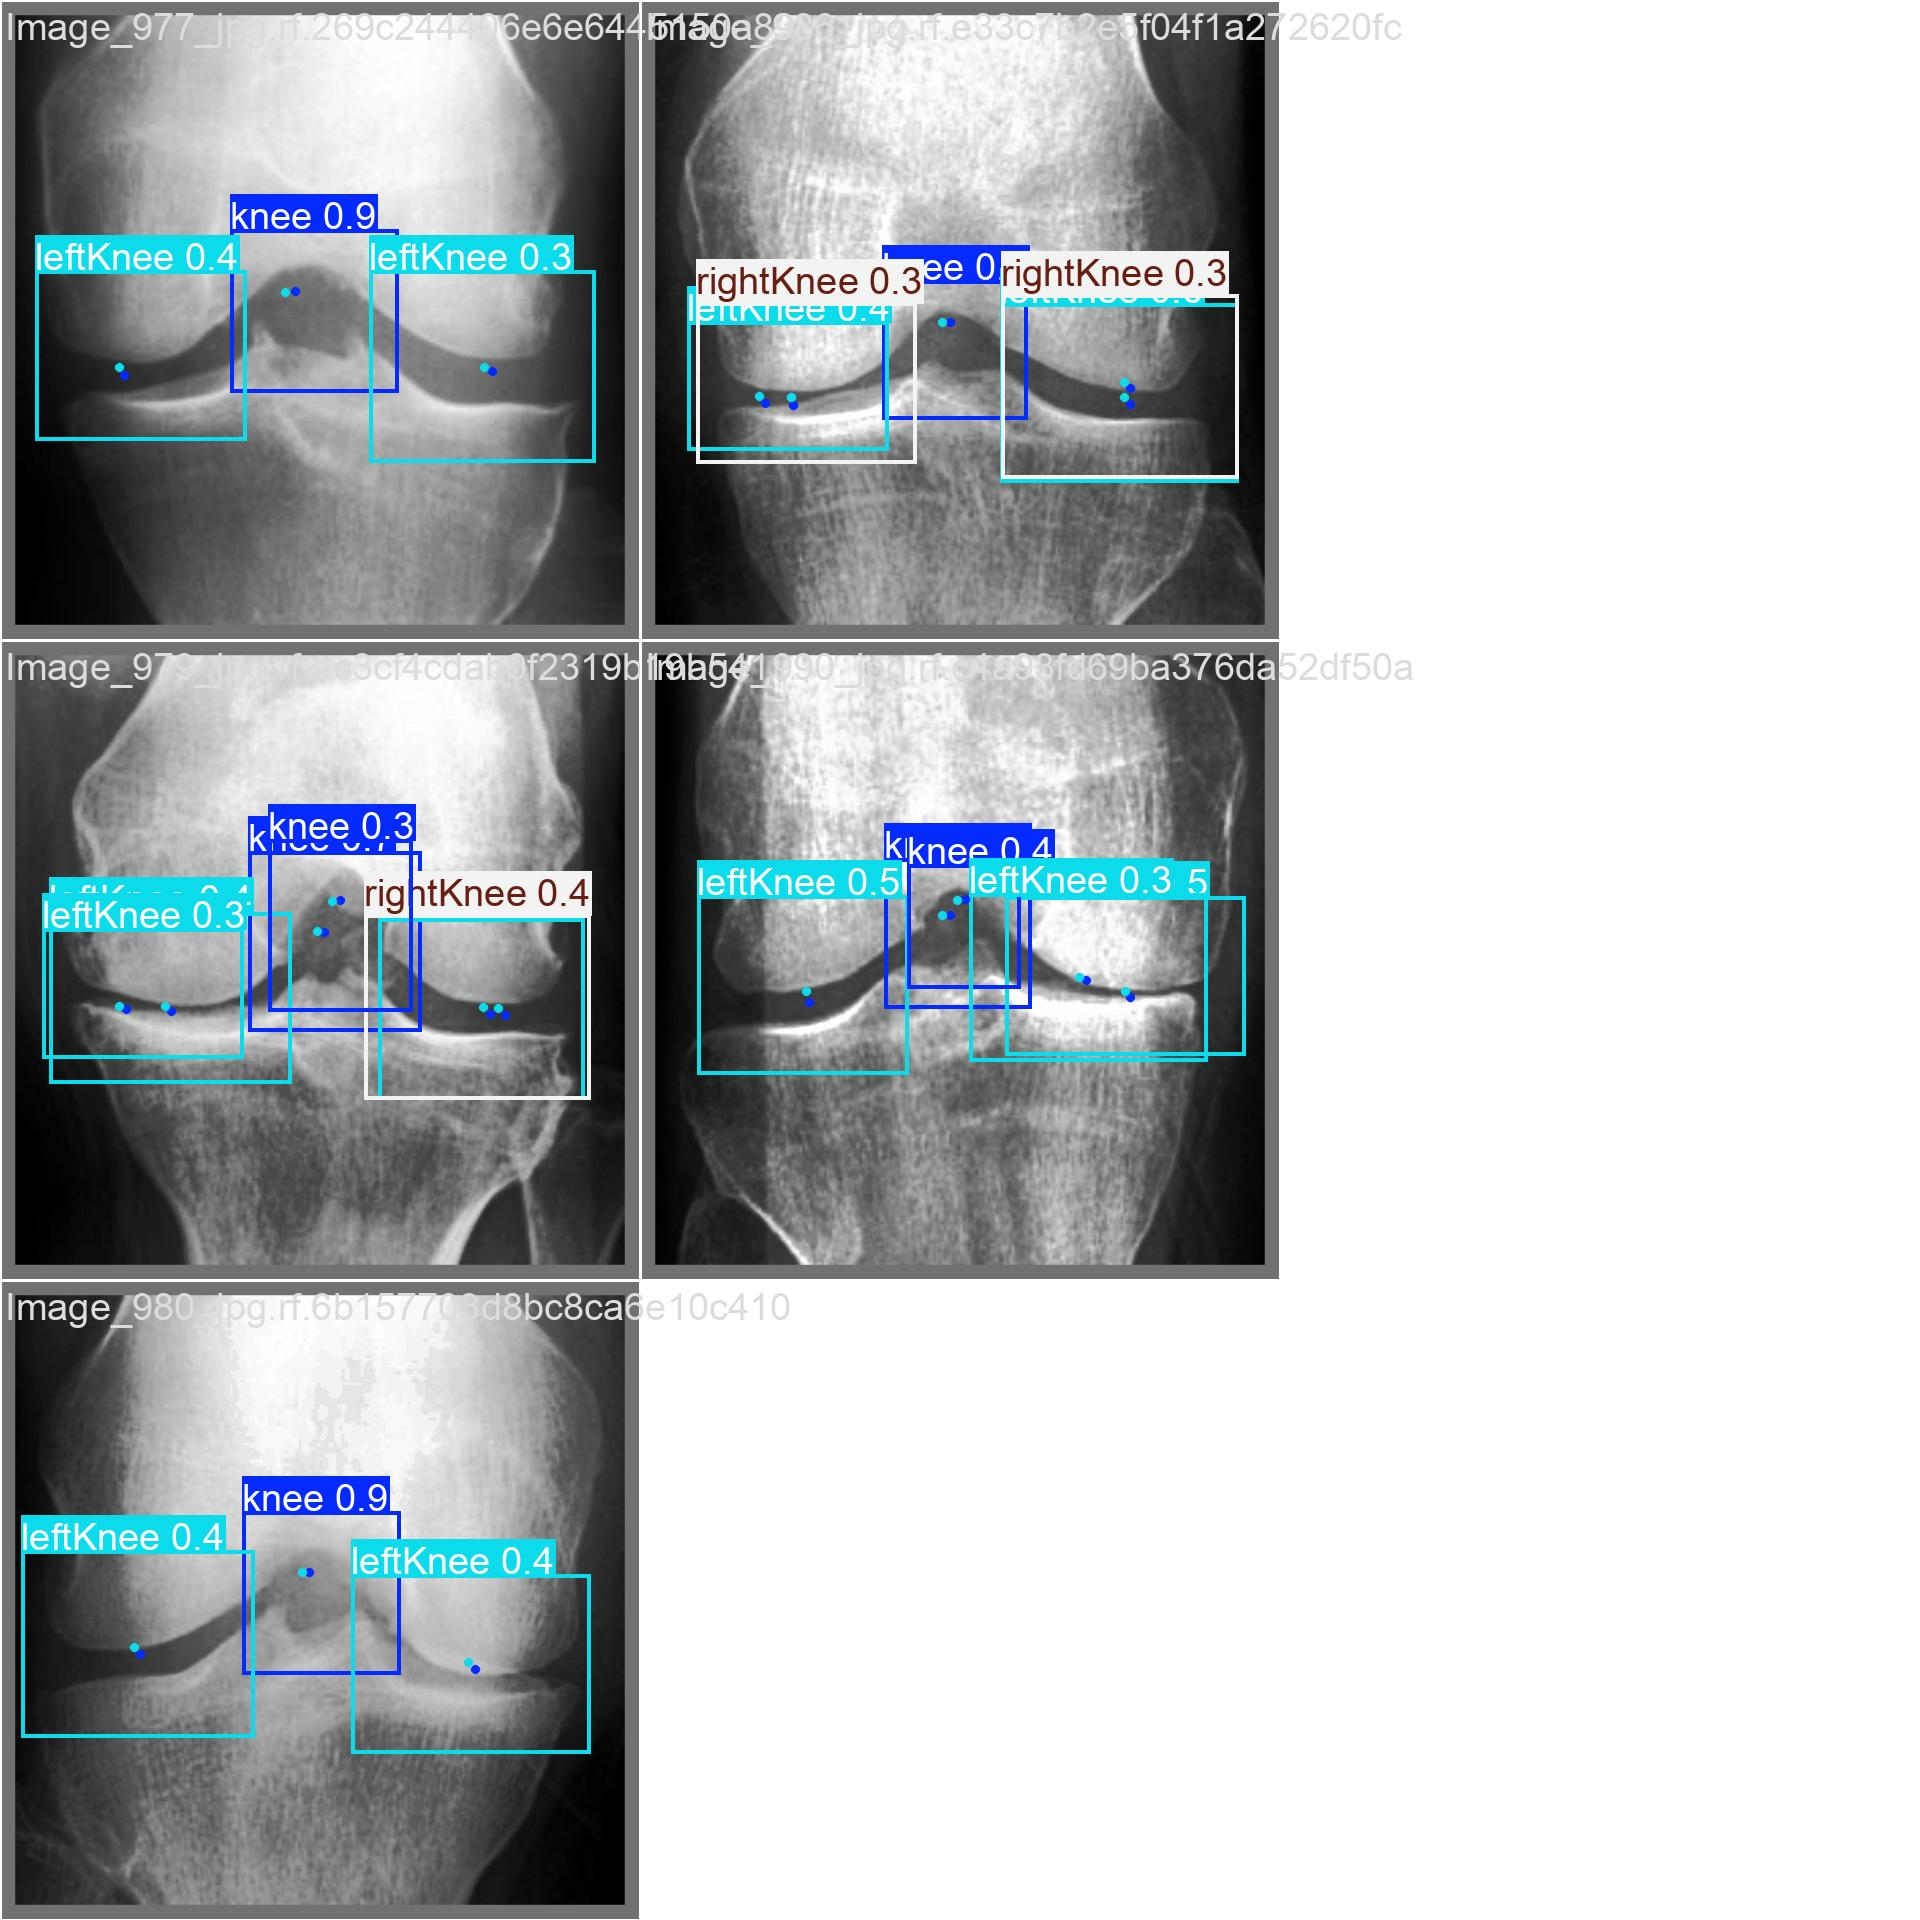

In [14]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/pose/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [15]:
!yolo task=detect mode=val model={HOME}/runs/pose/train/weights/best.pt data={dataset.location}/data.yaml

WARNING ⚠️ conflicting 'task=detect' passed with 'task=pose' model. Ignoring 'task=detect' and updating to 'task=pose' to match model.
Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n-pose summary (fused): 257 layers, 2,654,563 parameters, 0 gradients, 6.6 GFLOPs
val: Scanning /content/datasets/PointKneeDetectionV5-16/valid/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100% 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100% 1/1 [00:01<00:00,  1.12s/it]
                   all          5         15      0.604       0.82      0.778      0.434      0.604       0.82      0.778      0.738
                  knee          5          5      0.664          1      0.995      0.641      0.664          1      0.995      0.876
              leftKnee          5          5      0.455          1      0.553      0.277      0.455          1      0.553

## Inference with custom model

In [16]:
!yolo task=detect mode=predict model={HOME}/runs/pose/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

WARNING ⚠️ conflicting 'task=detect' passed with 'task=pose' model. Ignoring 'task=detect' and updating to 'task=pose' to match model.
Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n-pose summary (fused): 257 layers, 2,654,563 parameters, 0 gradients, 6.6 GFLOPs

image 1/3 /content/datasets/PointKneeDetectionV5-16/test/images/Image_976_jpg.rf.bec9324ec7c452d6eec4edd376c0cc09.jpg: 640x640 2 knees, 2 leftKnees, 12.6ms
image 2/3 /content/datasets/PointKneeDetectionV5-16/test/images/Image_987_jpg.rf.108d1da9850f381362c2209fa5703e99.jpg: 640x640 2 knees, 3 leftKnees, 15.2ms
image 3/3 /content/datasets/PointKneeDetectionV5-16/test/images/Image_995_jpg.rf.81080a8e19d0353984fa6bf6242e4ebc.jpg: 640x640 1 knee, 3 leftKnees, 9.5ms
Speed: 2.1ms preprocess, 12.4ms inference, 206.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/pose/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Let's take a look at few results.

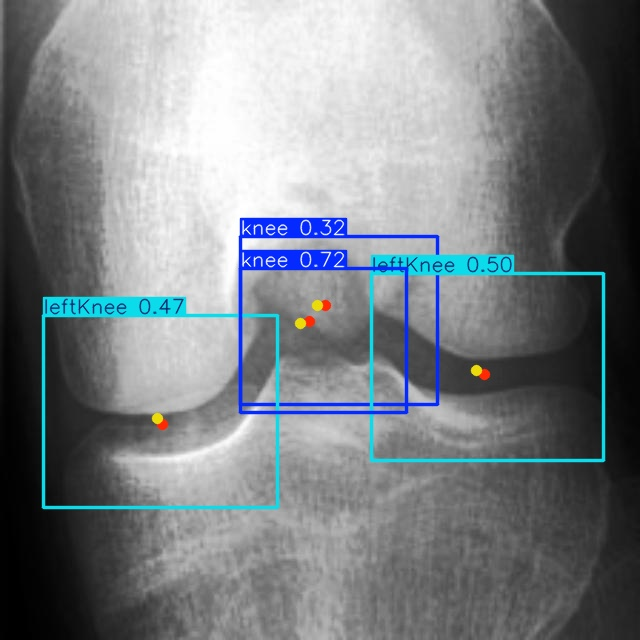

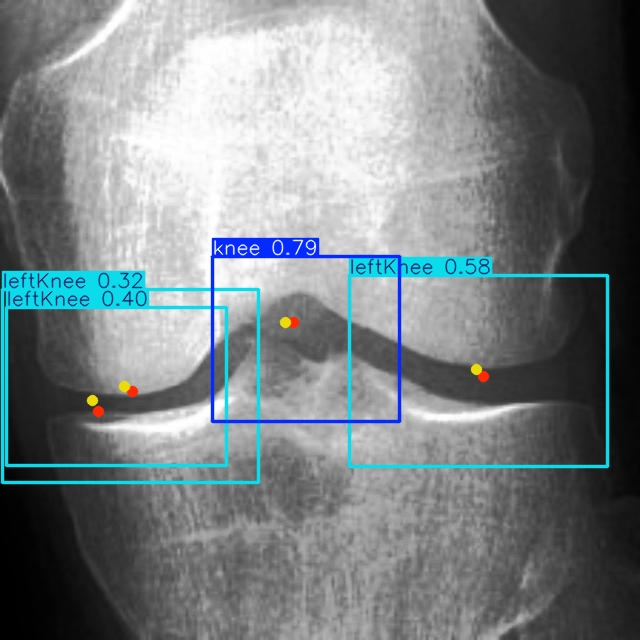

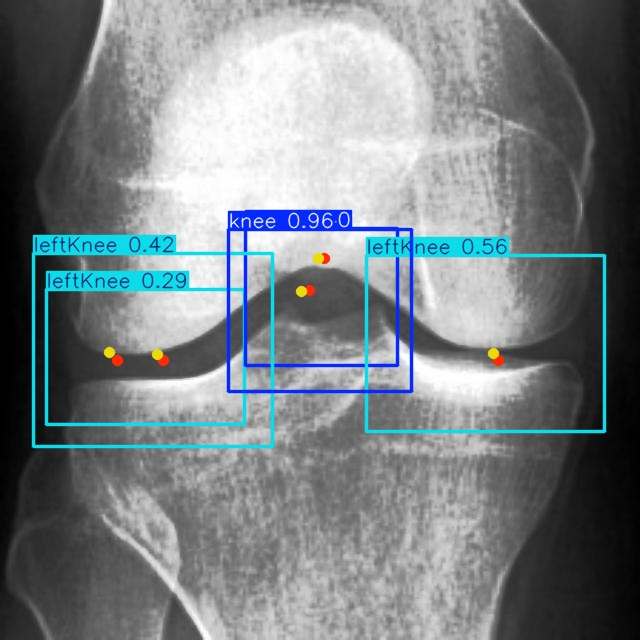

In [18]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/pose/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:5]:
    display(IPyImage(filename=img, width=600))
    print("\n")